In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import Preprocess
# from ProbabilisticMatrixFactorization import PMF
import tensorflow as tf
import rrn

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('../data/class/rating_data.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5

# Top List preprocess

In [3]:
df_item = pd.DataFrame(df['iid'])
df_item.column = ['iid']
df_item['freq'] = df_item.groupby('iid')['iid'].transform('count')
df_item = df_item.drop_duplicates()
df_item = df_item.sort_values(by=['freq'], ascending=False)
top_list = df_item['iid'].as_matrix()

top_ranks = []
for i in range(1, 10):
    top_ranks.append(top_list[:i*10])

# Data preprocessing

In [4]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def train_test_split(df, time_interval, split_rate= 0.125):
    start_time = min(df['timestamp'])
    end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    
    df_train = df[df['timestamp'] < split_time]
    df_test = df[df['timestamp'] >= split_time]
    
    return df_train, df_test

In [5]:
userList = np.unique(df['uid'])
itemList = np.unique(df['iid'])
user_map = get_map(userList)
item_map = get_map(itemList)
initial_time = min(df['timestamp'])

df_train, df_test = train_test_split(df, 3 * 30 * 24 * 3600)

## LOG_LOSS with AdaGrad

user_hparas = get_hparas('USER')
item_hparas = get_hparas('ITEM')

tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_hparas, item_hparas=item_hparas, lr=0.01, epochs=200, loss_function='log_loss')

model.train(df, user_vectors, item_vectors)


train_loss = model.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

## RMSE with Adam

In [6]:
user_vectors = np.load('../data/class/user_vectors.npy')
item_vectors = np.load('../data/class/item_vectors.npy')

item_train_list = np.unique(df_train['iid'])
item_test_list = np.unique(df_test['iid'])

user_train_hparas = {
            'NAME': 'USER',
            'EMBED_UNITS': 40,
            'BATCH_SIZE': 64,
            'LSTM_UNITS': 40,
            'LATENT_UNITS': 20,
            'ITEM_NUM': len(itemList)+3,
            'TRAIN_TIME_ELAPSE': 21,
            'TEST_TIME_ELAPSE': 3,
            'STATIONARY_LENGTH': 20,
        }

item_train_hparas = {
            'NAME': 'ITEM',
            'EMBED_UNITS': 40,
            'BATCH_SIZE': len(item_train_list),
            'LATENT_UNITS': 20,
            'LSTM_UNITS': 40,
            'TRAIN_TIME_ELAPSE': 21,
            'TEST_TIME_ELAPSE': 3,
            'USER_NUM': len(userList)+3,
            'STATIONARY_LENGTH': 20
        }

user_test_hparas = {
            'NAME': 'USER',
            'EMBED_UNITS': 40,
            'BATCH_SIZE': 64,
            'LSTM_UNITS': 40,
            'LATENT_UNITS': 20,
            'ITEM_NUM': len(itemList)+3,
            'TRAIN_TIME_ELAPSE': 21,
            'TEST_TIME_ELAPSE': 3,
            'STATIONARY_LENGTH': 20,
        }

item_test_hparas = {
            'NAME': 'ITEM',
            'EMBED_UNITS': 40,
            'BATCH_SIZE': len(item_test_list),
            'LATENT_UNITS': 20,
            'LSTM_UNITS': 40,
            'TRAIN_TIME_ELAPSE': 21,
            'TEST_TIME_ELAPSE': 3,
            'USER_NUM': len(userList)+3,
            'STATIONARY_LENGTH': 20
        }

# With Weighted

In [34]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=200, loss_function='log_loss', weighted=2)

In [35]:
model.train(df_train, user_map, item_map, initial_time, top_rank=top_ranks[2])

100%|██████████| 200/200 [00:51<00:00,  3.88it/s]


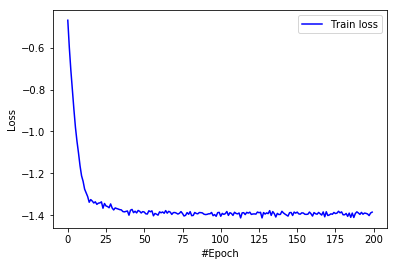

In [36]:
import matplotlib.pyplot as plt
train_loss = model.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

In [37]:
model.model_save(1)

tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load(1)
losses = model.test(df_test, user_map, item_map, initial_time, individually=False)
print (sum(losses)/len(losses))

In [38]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load(1)

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

INFO:tensorflow:Restoring parameters from model/rrn_1.ckpt
top10 log_loss loss: 0.548970
top20 log_loss loss: 1.099403
top30 log_loss loss: 1.649671
top40 log_loss loss: 2.200935
top50 log_loss loss: 2.754766
top60 log_loss loss: 3.309083
top70 log_loss loss: 3.862221
top80 log_loss loss: 4.413322
top90 log_loss loss: 4.964820

All items log_loss loss: 5.408109


# Without weighted

In [31]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=200, loss_function='log_loss', weighted=None)
model.train(df_train, user_map, item_map, initial_time, top_rank=None)
model.model_save(1)

100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


In [33]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load(1)

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

INFO:tensorflow:Restoring parameters from model/rrn_1.ckpt
top10 log_loss loss: 0.077089
top20 log_loss loss: 0.153570
top30 log_loss loss: 0.225993
top40 log_loss loss: 0.300649
top50 log_loss loss: 0.374824
top60 log_loss loss: 0.448181
top70 log_loss loss: 0.520606
top80 log_loss loss: 0.591560
top90 log_loss loss: 0.662763

All items log_loss loss: 0.720230


In [ ]:
prep = Preprocess(df_test, user_map, item_map, initial_time, 'zero_one')

user_input, item_input, ground_truth, batch_user, batch_item = prep.gen_batch(0)
u_static_vector = prep.get_latent_vector(batch_user, user_vectors, 'user')
i_static_vector = prep.get_latent_vector(batch_item, item_vectors, 'item')

In [ ]:
output = model.sess.run(
    model.logits,
    feed_dict={
        model.user_input: user_input,
        model.item_input: item_input,
        model.ground_truth: ground_truth,
        model.user_stationary_factor: u_static_vector,
        model.item_stationary_factor: i_static_vector,
    })

In [ ]:
print (output[0][1])